#importing Libraries



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

#Loading DataSet

In [2]:
df=pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


#EDA

<b>Initial Data Analysis <b>

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000



Dataset contains 918 rows and 12 columns.

No missing values across any columns.

No duplicate rows.

Data types:

Numerical: Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

Categorical: Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope

In [4]:
# from ydata_profiling import ProfileReport

# # Generate the profile report
# profile = ProfileReport(df, explorative=True)

# # Save the report as an HTML file
# profile.to_file("heart_disease_eda_report.html")


In [5]:
df['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

#Histograms for each numerical column


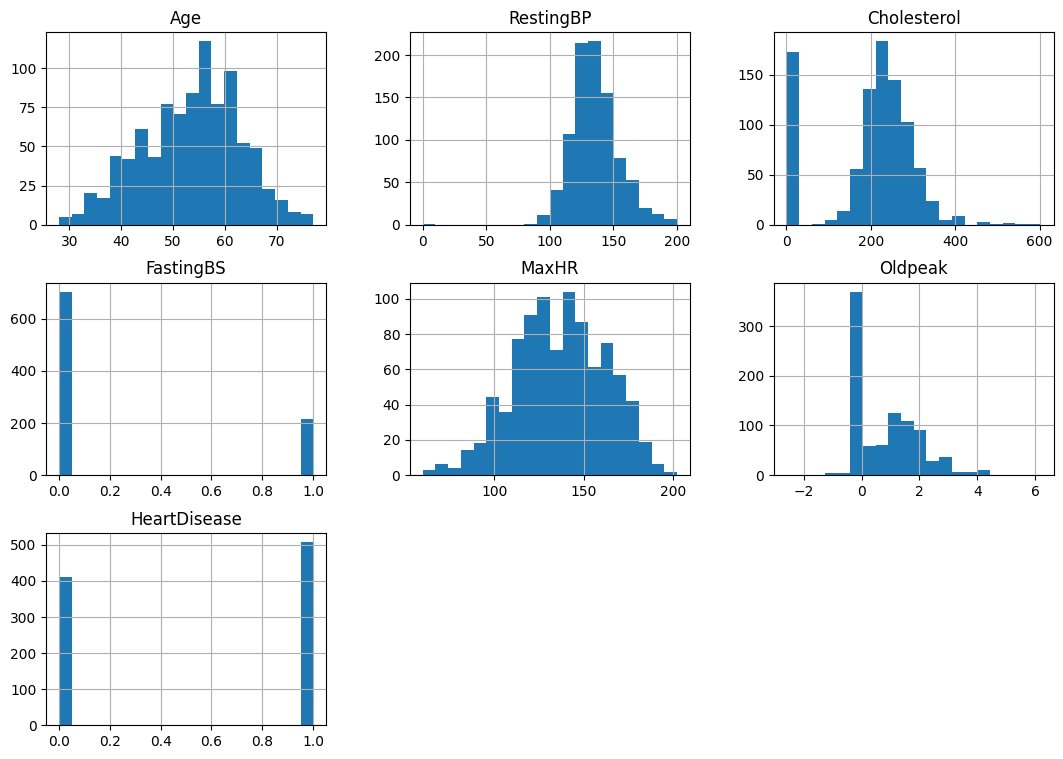

In [6]:
df.hist(figsize=(13,9),bins=20)
plt.show()

#Invalid values Detection

there are outliers in OldPeak,MaxHR,Cholesterol,RestingBp

In [7]:
print("there are Total:",len(df[df['Oldpeak']==0]),"no of rows having Oldpeak == 0")
print("there are Total:",len(df[df['Cholesterol']==0]),"no of rows having Oldpeak == 0")

there are Total: 368 no of rows having Oldpeak == 0
there are Total: 172 no of rows having Oldpeak == 0


The Cholesterol column in the dataset has biologically impossible values (0) since cholesterol levels cannot be zero in a living person. This indicates missing data that needs to be handled properly.

In [8]:
# Group by Sex and Age (binned) to impute more precisely
df['Age_Group'] = pd.cut(df['Age'], bins=[20, 40, 50, 60, 70, 80])
median_by_group = df[df['Cholesterol'] > 0].groupby(['Sex', 'Age_Group'])['Cholesterol'].median()
# # Fill missing values based on group
for (sex, age_group), median_val in median_by_group.items():
    mask = (df['Sex'] == sex) & (df['Age_Group'] == age_group) & (df['Cholesterol'] == 0)
    df.loc[mask, 'Cholesterol'] = median_val

# Drop Age_Group
df.drop('Age_Group', axis=1, inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_14472\4178237274.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_by_group = df[df['Cholesterol'] > 0].groupby(['Sex', 'Age_Group'])['Cholesterol'].median()
C:\Users\PC\AppData\Local\Temp\ipykernel_14472\4178237274.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '210.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'Cholesterol'] = median_val


After inserting median value in place of zero in cholesterol by considering age and sex

In [9]:
print("there are Total:",len(df[df['Cholesterol']==0]),"no of rows having Oldpeak == 0")

there are Total: 0 no of rows having Oldpeak == 0


#removing zero values for restingbp

Understanding RestingBP (Resting Blood Pressure)
RestingBP is a critical vital sign measuring the force of blood against artery walls when the heart is at rest (measured in mmHg). It's a key predictor of cardiovascular health.

1. Clinical Ranges & Interpretation

<div style="font-family: Arial; margin: 10px;">
<h3>Resting Blood Pressure Classification</h3>
<table border="1" style="border-collapse: collapse; width: 100%;">
  <tr style="background-color: #f2f2f2;">
    <th>Category</th>
    <th>Systolic (mmHg)</th>
    <th>Diastolic (mmHg)</th>
    <th>Risk Level</th>
  </tr>
  <tr>
    <td>Normal</td>
    <td><120</td>
    <td><80</td>
    <td style="color: green;">Healthy</td>
  </tr>
  <tr>
    <td>Elevated</td>
    <td>120-129</td>
    <td><80</td>
    <td style="color: orange;">Caution</td>
  </tr>
  <tr>
    <td>Hypertension Stage 1</td>
    <td>130-139</td>
    <td>80-89</td>
    <td style="color: #FF8C00;">Moderate Risk</td>
  </tr>
  <tr>
    <td>Hypertension Stage 2</td>
    <td>≥140</td>
    <td>≥90</td>
    <td style="color: red;">High Risk</td>
  </tr>
  <tr>
    <td>Hypertensive Crisis</td>
    <td>>180</td>
    <td>>120</td>
    <td style="color: darkred; font-weight: bold;">Emergency</td>
  </tr>
</table>
</div>

HTML(html_table)

Note: Our dataset likely records systolic BP (higher number).

there is a row where resting bp is 0 which is invalid data so we need to remoe the rows having bp<=0 or bp>250

In [10]:
# Drop rows where RestingBP is 0 or >250
df.drop(df[(df['RestingBP'] <= 0) | (df['RestingBP'] > 250)].index, inplace=True)


In [11]:
df.shape


(917, 12)

#Understanding MaxHR (Maximum Heart Rate)
MaxHR refers to the highest heart rate a person achieves during intense exercise. It's a critical metric in cardiovascular health assessment and is often used to gauge exercise intensity.

Typical Range:

Normal: 60–100 bpm (resting)

During Exercise: Can go up to 220 - Age (theoretical max)

Athletes: May have lower resting HR (40–60 bpm) but higher max capacity.

In [12]:
# STEP 1: Basic Validation
print("Initial MaxHR Statistics:")
print(df['MaxHR'].describe())

# STEP 2: Age-Adjusted Validation
df['Theoretical_Max'] = 220 - df['Age']
invalid_maxhr = df[df['MaxHR'] > df['Theoretical_Max']]
print(f"\nEntries exceeding age-adjusted max: {len(invalid_maxhr)}")

# STEP 3: Outlier Treatment (Recommended Approach)
df['MaxHR'] = np.where(
    df['MaxHR'] > df['Theoretical_Max'],
    df['Theoretical_Max'],
    df['MaxHR']
)

# STEP 4: Extreme Value Capping (Universal Boundaries)
df['MaxHR'] = df['MaxHR'].clip(lower=40, upper=220)

# STEP 5: Final Verification
print("\nPost-Cleaning Statistics:")
print(df['MaxHR'].describe())

Initial MaxHR Statistics:
count    917.000000
mean     136.789531
std       25.467129
min       60.000000
25%      120.000000
50%      138.000000
75%      156.000000
max      202.000000
Name: MaxHR, dtype: float64

Entries exceeding age-adjusted max: 87

Post-Cleaning Statistics:
count    917.000000
mean     136.078517
std       24.491651
min       60.000000
25%      120.000000
50%      138.000000
75%      155.000000
max      191.000000
Name: MaxHR, dtype: float64


In [13]:
df.drop('Theoretical_Max', axis=1, inplace=True)

#Oldpeak
. Typical Value Ranges
Value (mm)	Clinical Significance

>>0	Normal (no depression)

>>0.1–1.0	Mild depression (may need monitoring)

>>1.1–2.0	Moderate depression (higher risk)

>> greater than 2.0	Severe depression (likely ischemia)

In [14]:
# Check for negative values (biologically impossible)
negative_values = (df['Oldpeak'] < 0).sum()
print(f"Invalid negative Oldpeak entries: {negative_values}")

# Replace negatives with NaN (or remove)
df['Oldpeak'] = df['Oldpeak'].clip(lower=0)

Invalid negative Oldpeak entries: 13


#Outlier Detection and clipping

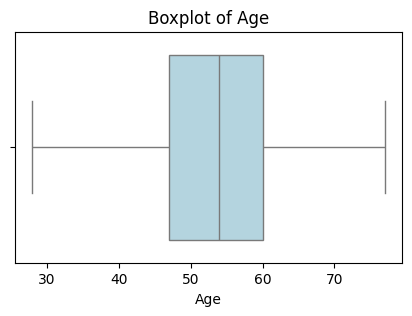

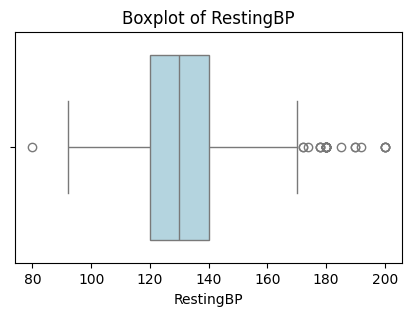

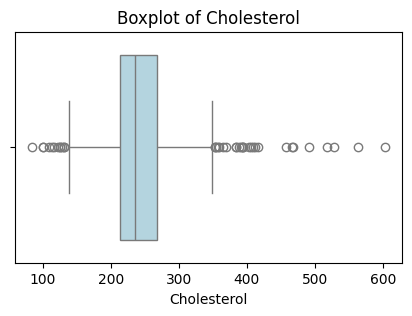

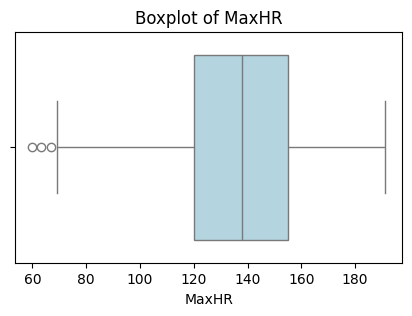

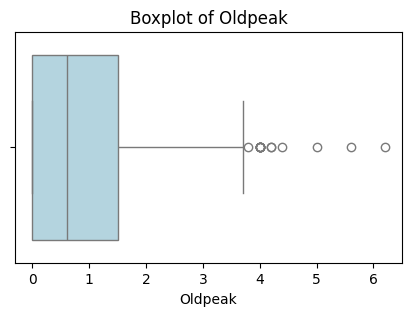

In [15]:
for col in ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f"Boxplot of {col}")
    plt.show()


In [16]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("heart.csv")

# Columns to process
cols = ['RestingBP', 'Cholesterol','Oldpeak','MaxHR']

for col in cols:
    # # Skip if column has missing/0 values (handle them first!)
    # if df[col].eq(0).any():
    #     print(f"⚠️ Column '{col}' has zeros. Handle missing values first!")
    #     continue

    # Calculate IQR bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds (adjust multiplier if needed)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip outliers
    df[col] = df[col].clip(lower_bound, upper_bound)

    print(f"Processed {col}: Bounds = [{lower_bound:.1f}, {upper_bound:.1f}]")

# Verify results
print("\nAfter outlier clipping:")
print(df[cols].describe())

Processed RestingBP: Bounds = [90.0, 170.0]
Processed Cholesterol: Bounds = [32.6, 407.6]
Processed Oldpeak: Bounds = [-2.2, 3.8]
Processed MaxHR: Bounds = [66.0, 210.0]

After outlier clipping:
        RestingBP  Cholesterol     Oldpeak       MaxHR
count  918.000000   918.000000  918.000000  918.000000
mean   132.125272   203.985158    0.877778  136.819172
std     16.993314    95.922341    1.031693   25.432057
min     90.000000    32.625000   -2.250000   66.000000
25%    120.000000   173.250000    0.000000  120.000000
50%    130.000000   223.000000    0.600000  138.000000
75%    140.000000   267.000000    1.500000  156.000000
max    170.000000   407.625000    3.750000  202.000000


after outliers cliping

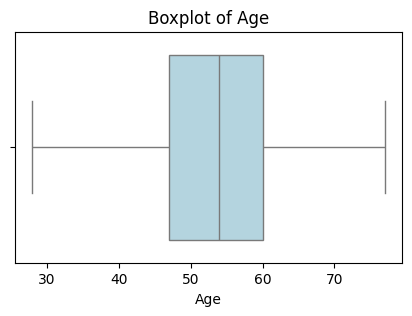

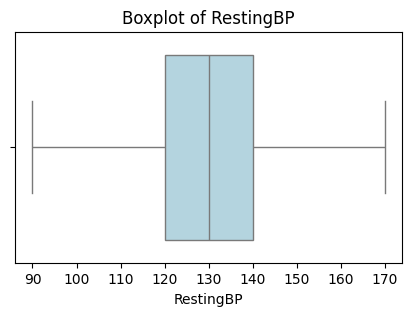

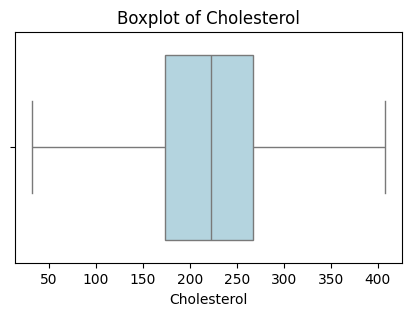

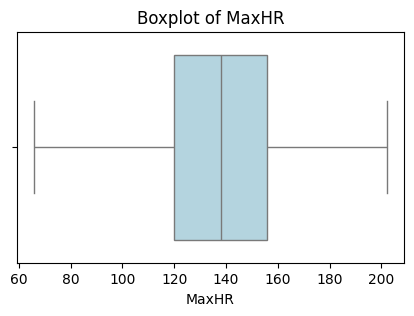

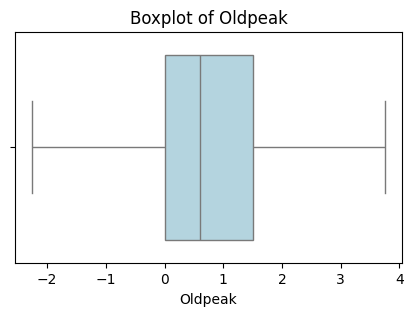

In [17]:
for col in ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f"Boxplot of {col}")
    plt.show()

#Coverting Categorical data to Numerical
Categorical: Sex, ChestPainType, RestingECG, ExerciseAngina,
<div style="font-family: Arial, sans-serif; margin: 20px; overflow-x: auto;">
  <h3 style="color: #2e6c80; border-bottom: 2px solid #2e6c80; padding-bottom: 5px;">Categorical Variable Encoding Guide</h3>
  <table style="border-collapse: collapse; width: 100%; margin-top: 15px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);">
    <thead>
      <tr style="background-color: #2e6c80; color: white;">
        <th style="padding: 12px 15px; text-align: left; border: 1px solid #ddd;">Variable</th>
        <th style="padding: 12px 15px; text-align: left; border: 1px solid #ddd;">Type</th>
        <th style="padding: 12px 15px; text-align: left; border: 1px solid #ddd;">Recommended Encoding</th>
        <th style="padding: 12px 15px; text-align: left; border: 1px solid #ddd;">Reason</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td style="padding: 12px 15px; border: 1px solid #ddd; background-color: #f9f9f9;"><strong>Sex</strong></td>
        <td style="padding: 12px 15px; border: 1px solid #ddd;">Nominal</td>
        <td style="padding: 12px 15px; border: 1px solid #ddd; color: #d35400;">One-Hot</td>
        <td style="padding: 12px 15px; border: 1px solid #ddd;">No inherent order (M/F are distinct categories)</td>
      </tr>
      <tr>
        <td style="padding: 12px 15px; border: 1px solid #ddd;"><strong>ChestPainType</strong></td>
        <td style="padding: 12px 15px; border: 1px solid #ddd;">Ordinal*</td>
        <td style="padding: 12px 15px; border: 1px solid #ddd; color: #d35400;">Ordinal</td>
        <td style="padding: 12px 15px; border: 1px solid #ddd;">If pain types have severity progression (e.g., TA > ATA > NAP > ASY)</td>
      </tr>
      <tr>
        <td style="padding: 12px 15px; border: 1px solid #ddd; background-color: #f9f9f9;"><strong>RestingECG</strong></td>
        <td style="padding: 12px 15px; border: 1px solid #ddd;">Nominal</td>
        <td style="padding: 12px 15px; border: 1px solid #ddd; color: #d35400;">One-Hot</td>
        <td style="padding: 12px 15px; border: 1px solid #ddd;">No clear order (Normal, ST, LVH are distinct)</td>
      </tr>
      <tr>
        <td style="padding: 12px 15px; border: 1px solid #ddd;"><strong>ExerciseAngina</strong></td>
        <td style="padding: 12px 15px; border: 1px solid #ddd;">Binary</td>
        <td style="padding: 12px 15px; border: 1px solid #ddd; color: #d35400;">Ordinal (0/1) or One-Hot</td>
        <td style="padding: 12px 15px; border: 1px solid #ddd;">Binary variables can use either method (Y/N → 1/0)</td>
      </tr>
    </tbody>
  </table>
  <p style="font-size: 14px; color: #666; margin-top: 10px; font-style: italic;">
    *Note for ChestPainType: Requires clinical validation of ordinality. If no clear order exists, treat as nominal.
  </p>
</div>

In [18]:
print(df['Sex'].value_counts())
print(df['ChestPainType'].value_counts())
print(df['RestingECG'].value_counts())
print(df['ExerciseAngina'].value_counts())
#

Sex
M    725
F    193
Name: count, dtype: int64
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64


In [19]:
# Feature Engineering
df.rename(columns={'HeartDisease': 'target'}, inplace=True)
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
onehot_cols = ['Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
preprocessor = ColumnTransformer([
    ('nominal', OneHotEncoder(), onehot_cols),
    ('ordinal', OrdinalEncoder(categories=[['TA', 'ATA', 'NAP', 'ASY']]), ['ChestPainType']),
    ('scaler', StandardScaler(), numerical_cols)
])


In [20]:
# Train-Test Split
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Above Values {1,0} percentiles are same in training and testing data because we used stratify

In [21]:

# Define Base Models
estimators = [
    ('xgb', XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)),
    ('svm', SVC(probability=True, kernel='rbf', C=1.0)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=5))
]

# Meta-model (logistic regression works well for medical data)
# Stacking Classifier
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(penalty='l2', C=0.1),
    cv=5
)


In [22]:
# Build Pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stack)
])

# Train Model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal', OneHotEncoder(),
                                                  ['Sex', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['TA',
                                                                              'ATA',
                                                                              'NAP',
                                                                              'ASY']]),
                                                  ['ChestPainType']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak'])])),
                ('model',
                 StackingClassifier(cv...
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=3,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('svm', SVC(probability=True)),
                                                ('rf',
                                                 RandomForestClassifier(max_depth=5))],
                                    final_estimator=LogisticRegression(C=0.1)))])

In [23]:
# Model Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(f"Stacking AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Stacking AUC: 0.9408
[[70 12]
 [ 6 96]]
              precision    recall  f1-score   support

           0       0.92      0.85      0.89        82
           1       0.89      0.94      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



In [24]:
import joblib
joblib.dump(model,'model.pk1')

['model.pk1']